**2021-12-09:** updated from Knut's CrowdingColor.ipynb notebook to read in the augmented joint-LF file **jointlf_gi_wVecs.fits** with the mag vectors packaged in the metadata. Also now takes the filter labels from the metadata.

* Also now includes interpolation along a locus in (mag0, mag1) space.
* Added prototype to determine the brightest magnitude closest to the requested target uncertainty (see cell 6)

**2021-12-10 10:50am EST:** Refactored the magnitude-picker into a method, added some condition traps for user-supplied target above or below the range of the confusion uncertainties. See cells 7 and 8. 


**2021-12-16 4:30pm EST:** Implemented a more robust method to find the magnitude-pair at which target confusion color uncertainty is reached: see method **calcNearestUncty()**. This will also handle edge cases better and should be faster than the older pickNearestUncty(), and it also optionally (but by default) interpolates to find the most accurate crossing point. At this point I recommend **calcNearestUncty()** to find the magnitudes that best match the target uncertainty.

To test this, try playing with the value of **colorIn** and **unctyTarg** in the cells below. To test the performance of the limit-matching algorithm in pathological cases, try setting **testInverted** to True.

In [1]:
import numpy as np
from scipy.interpolate import interp1d,griddata,interpn
from astropy.table import Table
import matplotlib.pylab as plt

def compCrowdError(magVector, lumFunc, seeing, singleMag=None):
        """
        Compute the crowding error for each observation

        Parameters
        ----------
        magVector : np.array
            Stellar magnitudes.
        lumFunc : np.array
            Stellar luminosity function.
        seeing : float
            The best seeing conditions. Assuming forced-photometry can use the best seeing conditions
            to help with confusion errors.
        singleMag : float (None)
            If singleMag is None, the crowding error is calculated for each mag in magVector. If
            singleMag is a float, the crowding error is interpolated to that single value.

        Returns
        -------
        np.array
            Magnitude uncertainties.


        Equation from Olsen, Blum, & Rigaut 2003, AJ, 126, 452
        """

        lumAreaArcsec = 3600.**2
        lumVector = 10**(-0.4*magVector)
        coeff=np.sqrt(np.pi/lumAreaArcsec)*seeing/2.
        myIntegral = (np.add.accumulate((lumVector**2*lumFunc)[::-1]))[::-1]
        temp = np.sqrt(myIntegral)/lumVector
        if singleMag is not None:
            interp = interp1d(magVector, temp)
            temp = interp(singleMag)

        crowdError = coeff*temp

        return crowdError

def compColorCrowdError(magVector1, magVector2, lumFunc12, seeing1, seeing2, singleMag1=None, singleMag2=None):
        """
        Compute the crowding error for each observation

        Parameters
        ----------
        magVector1 : np.array
            Stellar magnitudes in band 1.
        magVector2 : np.array
            Stellar magnitudes in band 2.
        lumFunc12 : np.array (2D)
            Joint stellar luminosity function in bands 1 and 2.
        seeing1 : float
            Seeing in band 1.
        seeing2 : float
            Seeing in band 2.
        singleMag1 : float (None)
            If singleMag is None, the crowding error is calculated for each mag in magVector. If
            singleMag is a float, the crowding error is interpolated to that single value.

        Returns
        -------
        np.array
            Magnitude uncertainties.


        Equation from Olsen, Blum, & Rigaut 2003, AJ, 126, 452
        """

        lumAreaArcsec = 3600.**2
        lumVector1, lumVector2 = np.meshgrid(10**(-0.4*magVector1), 10**(-0.4*magVector2))

        coeff=np.sqrt(np.pi/lumAreaArcsec)*np.min([seeing1,seeing2])/2.
        innerInt = np.add.accumulate(np.flip(lumVector1*lumFunc12),axis=1)
        outerInt = np.add.accumulate(np.flip(lumVector2)*innerInt,axis=0)
        int2d = np.flip(outerInt)

        temp = np.sqrt(int2d)/np.sqrt(lumVector1*lumVector2)

        crowdError12 = coeff*temp
        crowdError1 = compCrowdError(magVector1,np.sum(lumFunc12,axis=0),seeing1)
        crowdError2 = compCrowdError(magVector2,np.sum(lumFunc12,axis=1),seeing2)
        ce1, ce2 = np.meshgrid(crowdError1,crowdError2)
        
        colCrowdError = np.sqrt(ce1**2 + ce2**2 - 2*crowdError12**2)
        if singleMag1 is not None and singleMag2 is not None:
            interp = interp1d(magVector1, crowdError1)
            crowdError1 = interp(singleMag1)
            interp = interp1d(magVector2, crowdError2)
            crowdError2 = interp(singleMag2)
            #xvec,yvec = np.meshgrid(magVector1,magVector2)
            interp = interpn((magVector1,magVector2),colCrowdError,(singleMag1,singleMag2))
            colCrowdError = interp

        return crowdError1, crowdError2, colCrowdError


In [2]:
hpix=0

# 2021-12-09 updated to get the mag vectors from the fits file
useUpdated = False

tgi = Table.read('jointlf_gi_wVecs.fits')
gval = np.array(tgi.meta['MAGS0'])
ival = np.array(tgi.meta['MAGS1'])
filt0 = tgi.meta['FILT0']
filt1 = tgi.meta['FILT1']

if not useUpdated:
    gval = np.linspace(15,30,76)
    ival = np.linspace(12.5,27.5,76)
    
els = tgi['nest64']==hpix
gvec2, ivec2 = np.meshgrid(gval,ival)
lf12 = griddata((tgi[els][filt0],tgi[els][filt1]),tgi[els]['n'],(gvec2,ivec2),fill_value=0.)                                                        

sig_g,sig_i,sig_gi = compColorCrowdError(gval, ival, lf12, 1.0, 1.0)


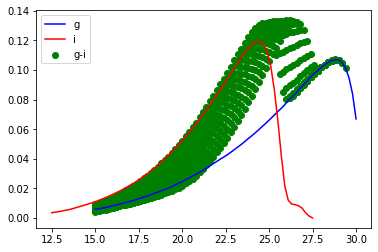

In [3]:
plt.plot(gval,sig_g,c='b', label=filt0)
plt.plot(ival,sig_i,c='r', label=filt1)
pk = ((gvec2-ivec2)>0) & ((gvec2-ivec2)<2)
plt.scatter(gvec2[pk],sig_gi[pk],c='g', label='%s-%s' % (filt0, filt1))
dum = plt.legend()

In [4]:
# try interpolating the grid of sig_gi so that we can draw a locus and
# interpolate over it
from scipy.interpolate import RectBivariateSpline
ff = RectBivariateSpline(gval, ival, sig_gi, kx=5, ky=5)

In [5]:
# make an artificial test case where the surface is flipped about 0.05 
# (to test the behavior of our methods that judge the brightest close crossing)
sig_gi_crazy = 0.10 - sig_gi
ffCrazy = RectBivariateSpline(gval, ival, sig_gi_crazy, kx=5, ky=5)

In [6]:
# let's try drawing a locus of constant color through this
colorIn = 0.5
xFine = np.copy(gval)
yFine = xFine - colorIn
locusLabel = 'locus: %s-%s=%.2f' % (filt0, filt1, colorIn)

# uncomment this to use a near-vertical locus instead
#xFine = np.linspace(24., 25., 50)
#yFine = np.linspace(np.min(ival), np.max(ival), np.size(xFine))
#locusLabel = 'locus: near vertical'

# Chop the arrays down so that we don't go out of the mag-mag space
bOK = (yFine >= np.min(ival)) & (yFine <= np.max(ival))
xFine = xFine[bOK]
yFine = yFine[bOK]

In [7]:
## now interpolate along the sequence and find the closest point to the desired 
## limit
#unctyTarg = 0.076 # pick to provoke double-values

## TODO - what to return if the crowding uncty requested is everywhere
## above or below the target value.

## we compute the evaluation here
#zeval = ff.ev(xFine, yFine)

## take the four points closest to the target and find the brightest...
#lSor4 = np.argsort(np.abs(zeval - unctyTarg))[0:4]
#iBri = np.argmin(yFine[lSor4])

## ... now select only those within 3x typical separation from the BRIGHTEST 
## of the points closest to the target. WATCHOUT need to handle iBri=last element
#spc = yFine[lSor4[iBri]+1] - yFine[lSor4[iBri]]
#bGood = yFine[lSor4] - yFine[lSor4[iBri]] < spc*3.

## The closest point is now the one nearest the target, out of the subset that
## are within a decent distance from the brightest point.
#iClose = np.argmin(np.abs(zeval[lSor4[bGood]] - unctyTarg))

#xClose = xFine[lSor4[bGood][iClose]]
#yClose = yFine[lSor4[bGood][iClose]]
#zClose = zeval[lSor4[bGood][iClose]]

In [8]:
# Method to return the magnitudes closest to the target uncertainty, along the locus
# in mag0, mag1 space defined by xFine, yFine
#
# (NOTE: when used within a class, we will likely have access to the various quantities
# needed so we won't need to pass in the various arguments. Should be simpler.)
#
# lSor4 (the indices of candidate closest matches) is currently returned so that we can
# conveniently plot those candidates in a following cell. In a class, this would be an 
# attribute that could be accessed from anywhere.

def pickNearestUncty(unctyTarg=0.076, xFine=np.array([]), yFine=np.array([]), \
                    ff=None):
    
    """Method to return the nearest mag1, mag2 to the target uncertainty. 
    
    Arguments:
    
    unctyTarg = target color uncertainty
    
    ff = bivariate spline object describing the interpolation of the surface
    
    xFine, yFine = mag0, mag1 arrays describing the locus
    
    Returns: xClose, yClose, zClose, lSor4
    
    """
    
    # do we have the surface spline? (If not we could reconstruct here if given the z values)
    try:
        zeval = ff.ev(xFine, yFine)
    except:
        return -99., -99., -99., np.array([])
    
    # If the target uncertainty is outside the range of values of zeval, return 
    # the supplied target uncertainty, and then magnitudes that are much fainter
    # or much brighter than the input range as appropriate. 
    if unctyTarg > np.max(zeval):
        return 99., 99., unctyTarg, np.array([])
    if unctyTarg < np.min(zeval):
        return -99., -99., unctyTarg, np.array([])
    
    # take the four points closest to the target and find the brightest...
    lSor4 = np.argsort(np.abs(zeval - unctyTarg))[0:4]
    iBri = np.argmin(yFine[lSor4])

    # Of the 4 closest points to the target, select only those within 3x typical 
    # separation from the BRIGHTEST of the points closest to the target. 
    # (Because we took the brightest four, it should be impossible for iBri 
    # to be the final point in the array. Nevertheless, we can be a bit 
    # defensive here.
    if lSor4[iBri]+1 == np.size(yFine):
        return xFine[lSor4[iBri]], yFine[lSor4[iBri]], zeval[lSor4[iBri]], lSor4
    
    spc = yFine[lSor4[iBri]+1] - yFine[lSor4[iBri]]
    bGood = yFine[lSor4] - yFine[lSor4[iBri]] < spc*3.

    # The closest point is now the one nearest the target, out of the subset that
    # are within a decent distance from the brightest point.
    iClose = np.argmin(np.abs(zeval[lSor4[bGood]] - unctyTarg))

    xClose = xFine[lSor4[bGood][iClose]]
    yClose = yFine[lSor4[bGood][iClose]]
    zClose = zeval[lSor4[bGood][iClose]]
    
    return xClose, yClose, zClose, lSor4

In [9]:
# This is similar to the above method but uses a different algorithm to find the 
# nearest location.

def calcNearestUncty(unctyTarg=0.076, xFine=np.array([]), yFine=np.array([]), \
                    ff=None, useNearest=False, constColor=None):
    
    """Method to return the nearest mag1, mag2 to the target uncertainty. 
    
    Arguments:
    
    unctyTarg = target color uncertainty. Scalar.
    
    xFine, yFine = mag0, mag1 1D arrays describing the locus
    
    ff = bivariate spline object describing the interpolation of the surface

    useNearest: return nearest value to the crossing rather than interpolating?
    
    constColor: if useInterp=True, then this color is added to the nearest value 
    of mag1 (i.e. xClose) to construct the mag2 value (i.e. yClose) to return.
    
    Returns: xClose, yClose, zClose, lSor4
    
    """
    
    # do we have the surface spline? (If not we could reconstruct here if given the z values)
    try:
        zeval = ff.ev(xFine, yFine)
    except:
        return -99., -99., -99., np.array([])
    
    # If the target uncertainty is outside the range of values of zeval, return 
    # the supplied target uncertainty, and then magnitudes that are much fainter
    # or much brighter than the input range as appropriate. 
    if unctyTarg > np.max(zeval):
        return 99., 99., unctyTarg, np.array([])
    if unctyTarg < np.min(zeval):
        return -99., -99., unctyTarg, np.array([])
    
    # Algorithm: at a crossing, the samples go from below to above the target level (in that order).
    # So, find the pairs that define crossings in that direction and pick the brightest. Then 
    # pick the nearest (vertically) of the two points in the pair 
    lOne = np.arange(xFine.size) # this could be argsort on some other property.
    lTwo = np.roll(lOne, -1)
    
    # Identify the candidate crossings...
    bCross = (zeval[lTwo] > zeval[lOne]) & \
        (zeval[lTwo] > unctyTarg) & \
        (zeval[lOne] <= unctyTarg) & \
        (xFine[lTwo] > xFine[lOne])
   
    # If there are no crossings in the increasing direction but the previous off-range conditions
    # were not triggered, then our limit must be at least as bright as the brightest point. So 
    # return that condition.
    if np.sum(bCross) < 1:
        return xFine[lOne[0]], yFine[lOne[0]], zeval[lOne[0]], np.array([])
    
    # ... find the brightest...
    lLo = lOne[bCross]
    iBri = np.argmin(xFine[lLo])
    lCross = np.array([lOne[bCross][iBri], lTwo[bCross][iBri] ])
    
    # For all reasonable crowding uncertainty curves, all points brighter than the first
    # crossing will have LOWER crowding uncertainty. However, let's make sure by adding
    # a condition: if any points brighter than the brightest crossing have greater crowding
    # uncertainty than either of the ends of the crossing, trap that condition and return.
    # In this case, the returned zeval will NOT be the same as the target uncertainty.
    bBri = xFine < xFine[lCross[0]]
    if np.sum(bBri) > 0:
        if np.max(zeval[bBri]) >= np.max(zeval[lCross]):
            iBri = np.argmax(zeval[bBri])
            return xFine[bBri][iBri], yFine[bBri][iBri], zeval[bBri][iBri], lCross
    
    # If we only want the closest of the input grid, return that here.
    if useNearest:
        lMin = np.argmin(np.abs(zeval[lCross] - unctyTarg))
        iMin = lCross[lMin]
        return xFine[iMin], yFine[iMin], zFine[iMin], lCross    
        
    # Otherwise, use our linear interpolation method
    xInterp = np.interp(unctyTarg, zeval[lCross], xFine[lCross])
    if constColor != None:
        yInterp = xInterp - constColor
    else:
        yInterp = np.interp(unctyTarg, zeval[lCross], yFine[lCross])
    
    return xInterp, yInterp, unctyTarg, lCross
    

In [10]:
# now try using the method
unctyTarg = 0.077

# unctyTarg = 0.022
# unctyTarg = 0.010
xClose, yClose, zClose, lSor4 = pickNearestUncty(unctyTarg, xFine, yFine, ff)

In [11]:
# test the new method instead.
testInverted = False
xClose, yClose, zClose, lSor4 = calcNearestUncty(unctyTarg, xFine, yFine, ff, \
                                                 constColor=0.5, useNearest=False)

if testInverted:
    # xClose, yClose, zClose, lSor4 = pickNearestUncty(unctyTarg, xFine, yFine, ffCrazy)
    xClose, yClose, zClose, lSor4 = calcNearestUncty(unctyTarg, xFine, yFine, ffCrazy, \
                                                 constColor=0.5, useNearest=False)

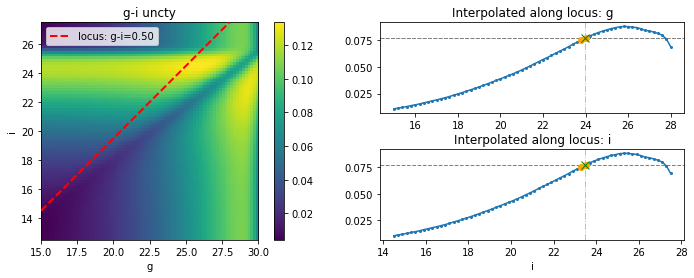

In [12]:
# plt.imshow(sig_gi)
fig3 = plt.figure(3, figsize=(12,4))
ax3 = fig3.add_subplot(121)

# If we inverted the surface to test the algorithm, ensure we plot the corresponding
# quantities.
sig_sho = np.copy(sig_gi)
zFine = ff.ev(xFine, yFine)
if testInverted:
    sig_sho = sig_gi_crazy
    zFine = ffCrazy.ev(xFine, yFine)
    
dum = ax3.imshow(sig_sho, extent=[np.min(gval), np.max(gval), np.min(ival), np.max(ival)], \
          origin='lower', interpolation='nearest')
ax3.set_xlabel(filt0)
ax3.set_ylabel(filt1)

cb = fig3.colorbar(dum, ax=ax3)

# Show the constant-color locus (watchout - locusLabel defined in the previous cell)
dum2 = ax3.plot(xFine, yFine, 'r--', zorder=5, lw=2, label=locusLabel)
leg2=ax3.legend()

# now show the interpolation
ax3b = fig3.add_subplot(222)
dum3b = ax3b.plot(xFine, zFine)
# ax3b.set_xlabel(filt0)  # label clashes with title below

ax3c = fig3.add_subplot(224)
dum3c = ax3c.plot(yFine, zFine)
# show scatterplot so we can find out if we should worry about quantization
dum3d = ax3b.scatter(xFine, zFine, s=4, zorder=4)
dum3d = ax3c.scatter(yFine, zFine, s=4, zorder=4)
ax3c.set_xlabel(filt1)

# set the titles
ax3.set_title('%s-%s uncty' % (filt0, filt1))
ax3b.set_title('Interpolated along locus: %s' % (filt0))
ax3c.set_title('Interpolated along locus: %s' % (filt1))
            
# overplot the closest to our target:
dum2h = ax3b.axhline(unctyTarg, color='0.5', ls='--', lw=1)
dum2point = ax3b.plot(xClose, zClose, 'gx', ms=8, zorder=8)
dum3h = ax3c.axhline(unctyTarg, color='0.5', ls='--', lw=1)
dum3point = ax3c.plot(yClose, zClose, 'gx', ms=8, zorder=8)

# show the candidate nearby points
if np.size(lSor4) > 0:
    dumdum2 = ax3b.scatter(xFine[lSor4], zFine[lSor4], color='orange', zorder=5)
    dumdum = ax3c.scatter(yFine[lSor4], zFine[lSor4], color='orange', zorder=5)
dumy = ax3c.axvline(yClose, color='0.75', ls='-.', lw=1)

# show the limit in g
dum3hx = ax3b.axhline(unctyTarg, color='0.5', ls='--', lw=1)
dumx = ax3b.axvline(xClose, color='0.75', ls='-.', lw=1)

fig3.subplots_adjust(hspace=0.4)

# 2021-12-16 some adjustments to zoom in on our trial area
# ax3b.set_xlim(23.5, 24.5)
# ax3b.set_ylim(0.07,0.085)


# ax3c.set_xlim(22., 24.)
# ax3c.set_ylim(0.07,0.085)


In [13]:
# 2021-12-09 WIC: commenting this out for the moment since it overwrites the definition
# of sig_gi used in the plots above

#sig_g,sig_i,sig_gi = compColorCrowdError(gval, ival, lf12, 1.0, 1.0, singleMag1=np.array([23.,24.,25.]),
#                                         singleMag2=np.array([23.,20.,25.]))
#print(sig_g,sig_i,sig_gi)